In [3]:
pip install tensorflow

  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [6]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


# Import Libraries and Data sets

In [94]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import cv2
import matplotlib.pyplot as plt

In [2]:
num_classes=10
input_shape=(32,32,3)

(x_train,y_train),(x_test, y_test)=keras.datasets.cifar10.load_data()


In [255]:
x_train = x_train[:1000]
y_train = y_train[:1000]
x_test = x_test[:200]
y_test = y_test[:200]

In [7]:
x_train.shape

(500, 32, 32, 3)

In [8]:
y_train.shape

(500, 1)

In [9]:
x_test.shape

(100, 32, 32, 3)

In [10]:
y_test.shape

(100, 1)

# Step 2: Hyper Parameter Definition

In [16]:
learning_rate=0.001
weight_decay=0.0001
batch_size=256
num_epochs=30
image_size=72
patch_size=6
num_patches=(image_size//patch_size)**2
projection_dim = 64
num_heads=4
transformer_units=[projection_dim*2,projection_dim]
transformer_layers =8 
mlp_head_units = [2048,1024]

# step 3: Build ViT Classifier Model

## 3.1 Data Augmentation

In [17]:
data_augmentation=keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],name="data_augmentation",) 
data_augmentation.layers[0].adapt(x_train)

## 3.2 Define MLP Architecture

In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x=layers.Dense(units,activation=tf.nn.gelu)(x)
        x=layers.Dropout(dropout_rate)(x)
    return x

## 3.3 Patches

In [19]:
class Patches(layers.Layer):
    def __init__(self,patch_size):
        super(Patches,self).__init__()
        self.patch_size = patch_size
        
    def call(self,images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images,sizes=[1,self.patch_size,self.patch_size,1],
                                          strides=[1,self.patch_size,self.patch_size,1],rates=[1,1,1,1],
                                          padding="VALID")
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches,[batch_size, -1,patch_dims])
        return patches

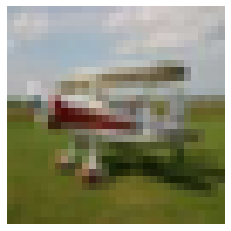

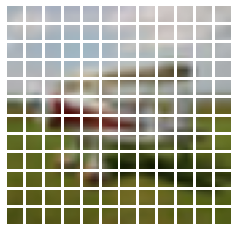

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis('off')

resized_image = tf.image.resize(tf.convert_to_tensor([image]),size=(image_size,image_size))
patches = Patches(patch_size)(resized_image)

n= int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n,n,i+1)
    patch_img = tf.reshape(patch,(patch_size,patch_size,3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [21]:
class PatchEncoder(layers.Layer):
    def __init__(self,num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches,output_dim=projection_dim)
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch)+self.position_embedding(positions)
        return encoded

In [22]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmentation = data_augmentation(inputs)
    patches = Patches(patch_size)(augmentation)
    encoded_patches= PatchEncoder(num_patches,projection_dim)(patches)
    
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads,key_dim=projection_dim,dropout=0.1)(x1,x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x4 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x4,x2])
        
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    features = mlp(representation,hidden_units=mlp_head_units,dropout_rate=0.5)
    logits =  layers.Dense(num_classes)(features)
    
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [23]:
def run(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    
    model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name="accuracy"),
                          tf.keras.metrics.SparseTopKCategoricalAccuracy(5,name="top_5_accuracy"),],)
    checkpoint_filepath= "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_filepath,monitor="val_accuracy",
                                                         save_best_only=True,save_weights_only=True)
    hostory = model.fit(x=x_train,y=y_train,batch_size=batch_size,epochs=num_epochs,validation_split=0.1,
                       callbacks=[checkpoint_callback],)
    
    _,accuracy,top_5_accuracy =  model.evaluate(x_test,y_test)
    print(f"Test Accuracy: {round(accuracy*100),2}%")
    print(f"Test Top 5 Accuracy: {round(top_5_accuracy*100),2}%")

In [24]:
vit_classifier = create_vit_classifier()
history = run(vit_classifier)

Epoch 1/30
2/2 [==============================] - 70s 24s/step - loss: 5.0379 - accuracy: 0.5800 - top_5_accuracy: 0.5800 - val_loss: 5.3430 - val_accuracy: 0.5800 - val_top_5_accuracy: 0.5800
Epoch 2/30
2/2 [==============================] - 94s 25s/step - loss: 6.7913 - accuracy: 0.5956 - top_5_accuracy: 0.5956 - val_loss: 3.3321 - val_accuracy: 0.6600 - val_top_5_accuracy: 0.6600
Epoch 3/30
2/2 [==============================] - 38s 20s/step - loss: 4.5221 - accuracy: 0.5956 - top_5_accuracy: 0.5956 - val_loss: 2.4821 - val_accuracy: 0.8200 - val_top_5_accuracy: 0.8200
Epoch 4/30
2/2 [==============================] - 31s 14s/step - loss: 3.3467 - accuracy: 0.6667 - top_5_accuracy: 0.6667 - val_loss: 2.6303 - val_accuracy: 0.6400 - val_top_5_accuracy: 0.6400
Epoch 5/30
2/2 [==============================] - 29s 13s/step - loss: 2.8555 - accuracy: 0.6600 - top_5_accuracy: 0.6600 - val_loss: 2.2137 - val_accuracy: 0.6600 - val_top_5_accuracy: 0.6600
Epoch 6/30
2/2 [===================

# labeling the images in the dataset

In [25]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
     'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]



# Predicting The image

In [194]:
from PIL import Image
import matplotlib.image as img

In [195]:
def img_prediction(images,model):
    if len(image.shape)==3:
        out = model.predict(images.reshape(-1,*images.shape))
    else:
        out=model.predict(images)
    prediction=np.argmax(out,axis=1)
    img_prediction = [class_names[i] for i in prediction]
    return img_prediction

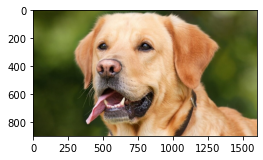

In [252]:
image = img.imread('d1.jpg')
plt.figure(figsize=(4,4))
plt.imshow(image.astype("uint8"))
plt.imshow(image)

In [253]:
image = np.array(image)
tf.image.convert_image_dtype(
    image, dtype=tf.uint8, saturate=False
)

<tf.Tensor: shape=(900, 1600, 3), dtype=uint8, numpy=
array([[[ 49,  59,   7],
        [ 49,  59,   7],
        [ 49,  59,   7],
        ...,
        [133, 138,  82],
        [133, 138,  82],
        [133, 138,  82]],

       [[ 49,  59,   7],
        [ 49,  59,   7],
        [ 49,  59,   7],
        ...,
        [132, 137,  81],
        [133, 138,  82],
        [133, 138,  82]],

       [[ 49,  59,   7],
        [ 49,  59,   7],
        [ 49,  59,   7],
        ...,
        [132, 137,  81],
        [132, 137,  81],
        [133, 138,  82]],

       ...,

       [[ 31,  40,  13],
        [ 30,  39,  12],
        [ 29,  38,   9],
        ...,
        [219, 165, 119],
        [218, 164, 117],
        [218, 164, 117]],

       [[ 31,  40,  13],
        [ 30,  39,  12],
        [ 29,  38,   9],
        ...,
        [219, 165, 119],
        [218, 164, 117],
        [218, 164, 117]],

       [[ 31,  40,  13],
        [ 30,  39,  12],
        [ 29,  38,   9],
        ...,
        [219, 165, 1

1/1 [==============================] - 0s 56ms/step
['dog']


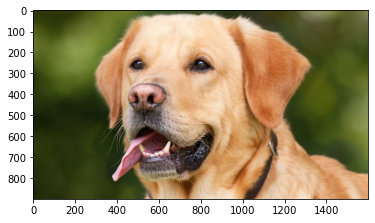

In [254]:
prediction = img_prediction(image,vit_classifier)
plt.imshow(image)
print(prediction)

1/1 [==============================] - 0s 39ms/step
['dog']


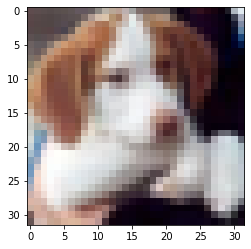

In [224]:
index=16
plt.imshow(x_test[index])
prediction = img_prediction(x_test[index],vit_classifier)
print(prediction)